In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys, os
sys.path.append("../../../gempy/")
import gempy as gp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
# from gempy.utils import stochastic_surface as ss
# from gempy.bayesian.posterior_analysis import calculate_probability_lithology, calculate_information_entropy
from gempy.assets import topology as tp
from tqdm import tqdm_notebook
import seaborn as sns

sys.path.append("../../../toolbox")
from toolbox import plot as ph

C:\Users\r02as18\miniconda3\envs\topology\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
geo_model = gp.create_model('Demo')
extent = [0,2000.,0,2000.,0,2000.]
gp.init_data(geo_model, extent,[50,50,50], 
      path_o = "../input_data/simple_fault_model_orientations.csv",
      path_i = "../input_data/simple_fault_model_points.csv", default_values=True); #%%

gp.map_series_to_surfaces(geo_model,
                            {"Fault_Series":'Main_Fault', 
                             "Strat_Series": ('Sandstone_2','Siltstone',
                                              'Shale', 'Sandstone_1', 'basement')}, remove_unused_series=True);

geo_model.set_is_fault(['Fault_Series'])

# groups = pickle.load(open("surf_pts_groups.p", "rb"))
# geo_model.surface_points.df["group"] = groups
# geo_model.orientations.df["group"] = None

C:\Users\r02as18\miniconda3\envs\topology\lib\site-packages\theano\gpuarray\dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.


,isFault,isFinite
Fault_Series,True,False
Strat_Series,False,False


In [3]:
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_compile',
    verbose=[]
)


Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!


In [4]:
sol = gp.compute_model(geo_model, compute_mesh=True)

In [5]:
from importlib import reload

In [6]:
reload(tp)

<module 'gempy.assets.topology' from '../../../gempy\\gempy\\assets\\topology.py'>

In [7]:
edges, ctrs = tp.compute_topology(geo_model)

In [8]:
lb = geo_model.solutions.lith_block.astype(int)
shp = geo_model.grid.regular_grid.resolution

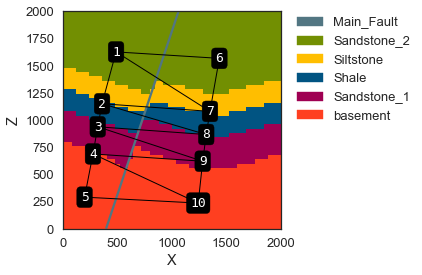

In [10]:
gp.plot.plot_section(geo_model, 24)
gp.plot.plot_topology(geo_model, edges, ctrs)

In [14]:
fb = tp._get_fb(geo_model)

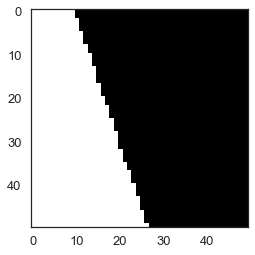

In [16]:
plt.imshow(fb[:, 24, :].T)

In [100]:
block_matrix = geo_model.solutions.block_matrix
n_faults = 1
n_shift = 5
from nptyping import Array

In [101]:
# faults
fault_matrix_sum = block_matrix[:n_faults].sum(axis=0)
fault_shift = fault_matrix_sum.min()
fault_matrix_sum_shift = fault_matrix_sum - fault_shift

# liths
lith_matrix = block_matrix[-1]
lith_shift = lith_matrix.min()
lith_matrix_shift = lith_matrix - lith_shift + 1

# combine
topo_matrix = lith_matrix_shift + n_lith * fault_matrix_sum_shift

# topo analysis
topo_matrix_3D = topo_matrix.reshape(*res)


def edges(
        l:Array[int, ..., ..., ...], 
        r:Array[int, ..., ..., ...]
    ) -> Array[int, ..., 2]:
    """Get edges from given shifted arrays.
    
    Args:
        l (Array): Topology labels array shifted to one direction.
        r (Array): Topology labels array shifted to the other direction.
    
    Returns:
        Array: Topology edges.
    """
    shift = np.stack([l.ravel(),  r.ravel()])
    i1, i2 = np.nonzero(np.diff(shift, axis=0))
    return np.unique(shift[:, i2], axis=1).T


# x direction
x_l = topo_matrix_3D[n_shift:,:,:]
x_r = topo_matrix_3D[:-n_shift,:,:]
x_edges = edges(x_l, x_r)

# y direction
y_l = topo_matrix_3D[:, n_shift:,:]
y_r = topo_matrix_3D[:, :-n_shift,:]
y_edges = edges(y_l, y_r)

# z direction
z_l = topo_matrix_3D[:, :, n_shift:]
z_r = topo_matrix_3D[:, :, :-n_shift]
z_edges = edges(z_l, z_r)

# unique of all edges
edges = np.unique(np.concatenate((x_edges, y_edges, z_edges), axis=0), axis=0)

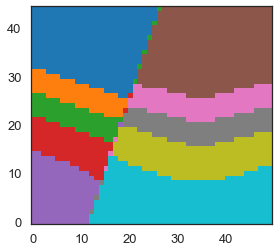

In [108]:
plt.imshow(z_l[:, 24, :].T, origin="lower", cmap="tab10")

In [43]:
res = geo_model.grid.regular_grid.resolution

In [ ]:
lb = tp._get_lb(geo_model)

In [20]:
fault_matrix_sum = fb.flatten()
lith_matrix = lb.flatten()

In [22]:
fault_shift = fault_matrix_sum.min()
fault_shift

1

In [28]:
n_lith = len(np.unique(lb))

In [34]:
fault_matrix_sum_shift = fault_matrix_sum - fault_shift
fault_matrix_sum_shift

array([0, 0, 0, ..., 1, 1, 1])

In [33]:
where = np.tile(lith_matrix, (n_lith, 1)) == np.unique(lith_matrix).reshape(-1, 1)
where

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [35]:
lith_matrix_shift = np.sum(where * np.arange(n_lith).reshape(-1, 1), axis=0) + 1

In [36]:
lith_matrix_shift

array([5, 5, 5, ..., 1, 1, 1])

In [37]:
lith_matrix

array([6, 6, 6, ..., 2, 2, 2])

In [38]:
topo_matrix = lith_matrix_shift + n_lith * fault_matrix_sum_shift

In [39]:
topo_matrix

array([5, 5, 5, ..., 6, 6, 6])

In [51]:
topo_matrix_3D = topo_matrix.reshape(*res)

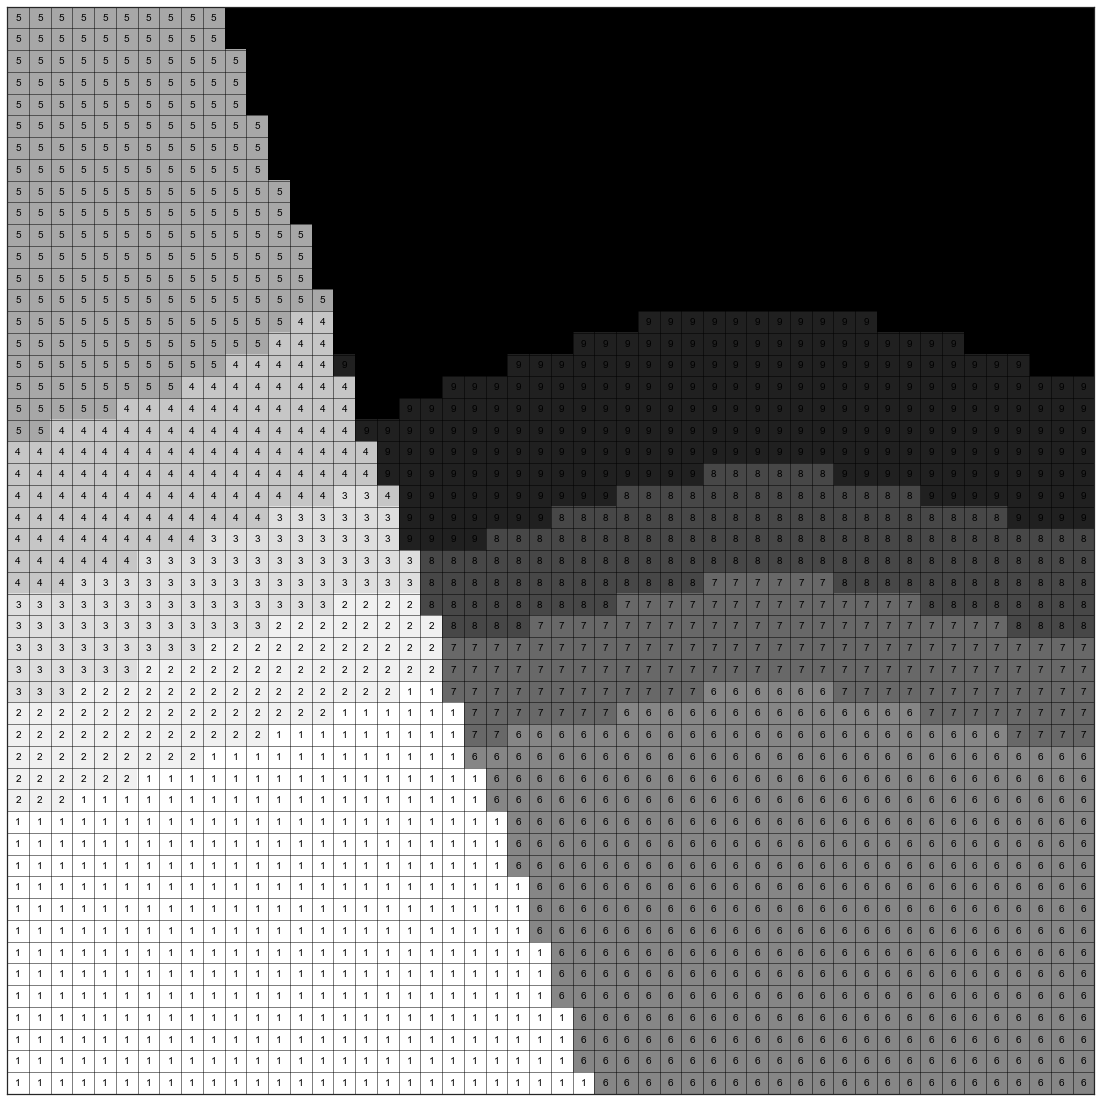

In [52]:
fig, ax = plt.subplots(figsize=(20,20))
plot(topo_matrix_3D[:, 24, :].T, ax=ax)

In [73]:
n_shift = 2

In [74]:
x_l = topo_matrix_3D[n_shift:, :, :]
x_r = topo_matrix_3D[:-n_shift, :, :]

In [75]:
y_l = topo_matrix_3D[:, n_shift:, :]
y_r = topo_matrix_3D[:, :-n_shift, :]

In [76]:
z_l = topo_matrix_3D[:, :, n_shift:]
z_r = topo_matrix_3D[:, :, :-n_shift]

In [77]:
shift = np.stack([z_l.ravel(), z_r.ravel()])

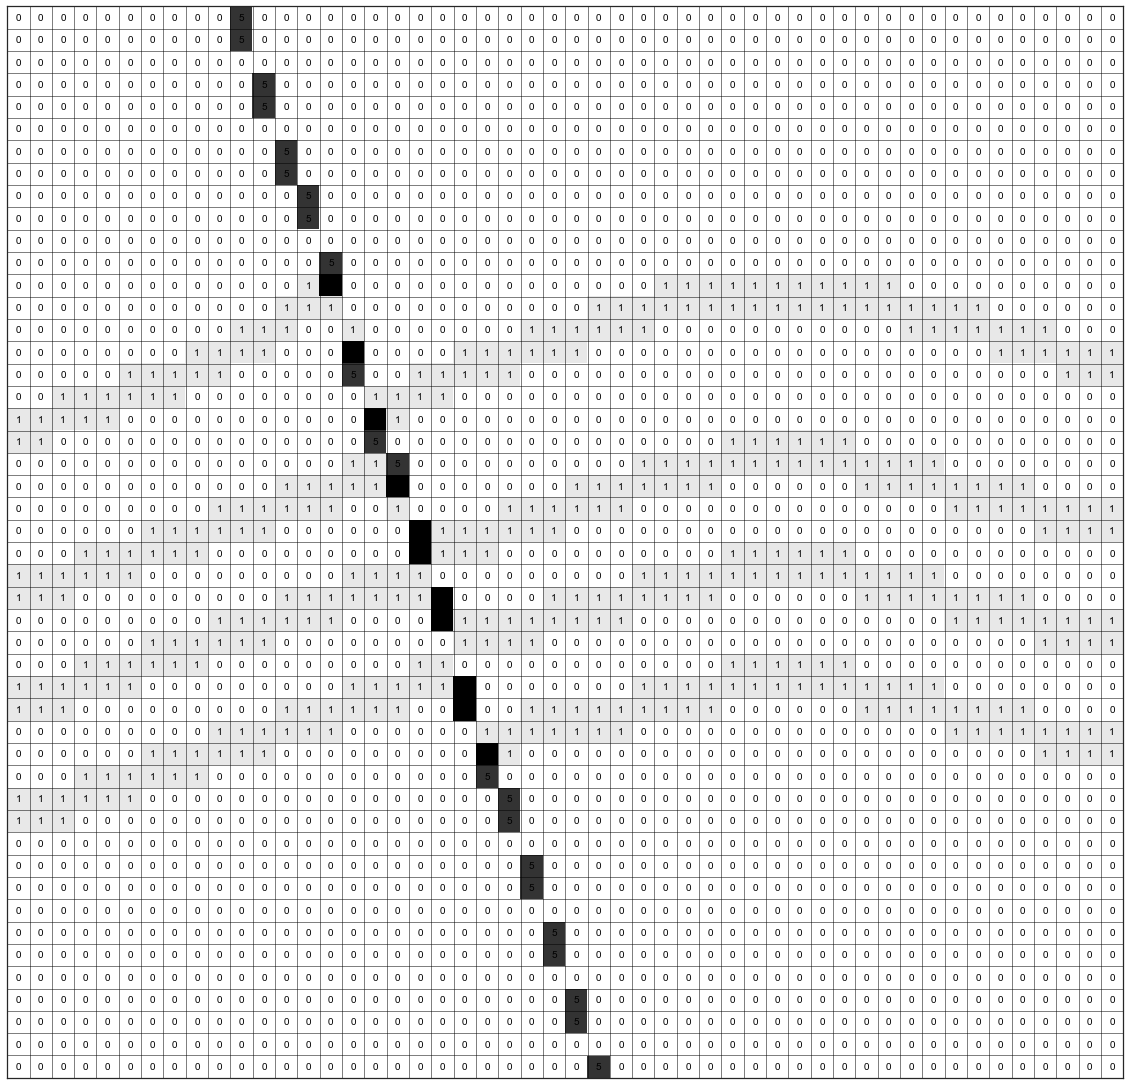

In [78]:
fig, ax = plt.subplots(figsize=(20,20))
plot(np.diff(shift, axis=0).reshape(50,50,48)[:, 24, :].T, ax=ax)

In [47]:
from matplotlib import cm


def plot(
    block: np.ndarray,
    ax = None,
    imshow_kwargs = {},
    text_kwargs = {}
):
    if not ax:
        fig, ax = plt.subplots()
        
    text_kwargs.update(
        dict(
            verticalalignment="center", 
            horizontalalignment="center"
        )
    )

    ax.imshow(block, **imshow_kwargs)
    
    xs = np.arange(0, block.shape[1], 1)
    ys = np.arange(0, block.shape[0], 1)

    ax.set_xticks(xs);
    ax.set_yticks(ys);

    ax.set_xticks(np.arange(-.5, block.shape[1], 1), minor=True);
    ax.set_yticks(np.arange(-.5, block.shape[0], 1), minor=True);
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none') 
    
    ax.grid(which='minor', color='k', linestyle='solid', linewidth=1, alpha=0.5)
    
    cmap = cm.__dict__.get(imshow_kwargs.get("cmap", "viridis"))
    
    for x in xs:
        for y in ys:
            id_ = block[y, x]
            text = str(int(id_))
            color = (0,0,0,1)
            ax.text(x, y, text, color=color, **text_kwargs)
    
    return ax

In [84]:
import pickle

In [88]:
priors = pickle.load(open("data/abc/priors.p", "rb"))

In [10]:
TEXTWIDTH = 503.61377

In [27]:
lb = geo_model.solutions.lith_block.astype(int)

In [11]:
from matplotlib import colors

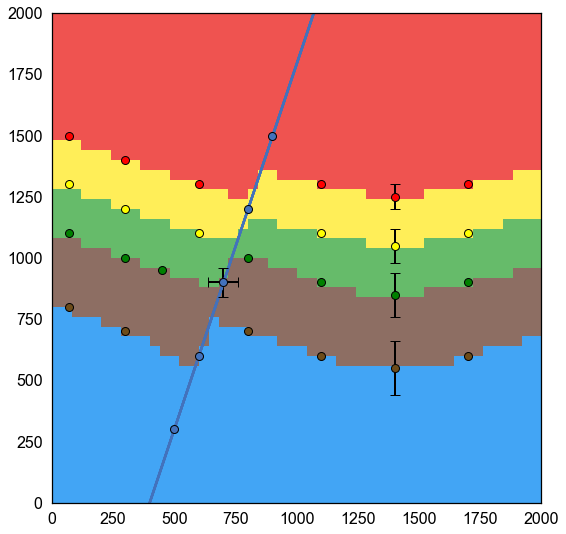

In [113]:
COLORS = ("#EF5350", "#FFEE58", "#66BB6A", "#8D6E63", "#42A5F5")
cmap = colors.ListedColormap(COLORS)
bounds = [2, 3, 4, 5, 6, 7]
norm = colors.BoundaryNorm(bounds, ncolors=6)


fontsize = 16
img = geo_model.solutions.lith_block.astype(int).reshape(50,50,50)[:, 24, :]
with plt.rc_context(ph.get_rcparams(fontsize)):
    fig, ax = plt.subplots(
        figsize=(10,10)
    )

    im = ax.imshow(
        img.T, origin="lower", extent=extent[:4], cmap=cmap, norm=norm
    )

    for prior, color in zip(priors,
                            ["red", "yellow", "green", "#6d4c1a", "#4372bc",
                             "#4372bc"]):
        f1 = geo_model.surface_points.df["surface"] == prior.name[:-2]
        f2 = geo_model.surface_points.df["Y"] == 1000.
        f = f1 & f2
        X = geo_model.surface_points.df[f].X.values
        Z = geo_model.surface_points.df[f].Z.values
        
        ax.plot(
            [400, 1070],
            [0, 2000],
            color="#4372BC"
        )

        for x, z in zip(X, Z):
            if prior.column == "Z":
                if x == 0:
                    x = + 70
                ax.plot(x, z, "o", markersize=8, color=color, markeredgewidth=1,
                         markeredgecolor="black")
                if x > 1250 and x < 1500 or x > 650 and x < 750:
                    (_, caps, _) = ax.errorbar(x, z, yerr=prior.std(),
                                                color="black", linewidth=2, alpha=1, capsize=5)
                    for cap in caps:
                        cap.set_markeredgewidth(1)
                        cap.linewidth = 1
            elif prior.column == "X":
                if x > 1250 and x < 1500 or x > 650 and x < 750:
                    (_, caps, _) = ax.errorbar(x, z, xerr=prior.std(),
                                                color="black", linewidth=2, alpha=1, capsize=5)
                    for cap in caps:
                        cap.set_markeredgewidth(1)
                        cap.linewidth = 1

In [62]:
img[::5, ::5].T

array([[6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       [6, 6, 6, 6, 6, 6, 5, 5, 5, 6],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

In [57]:
from gempy.plot.vista import Vista

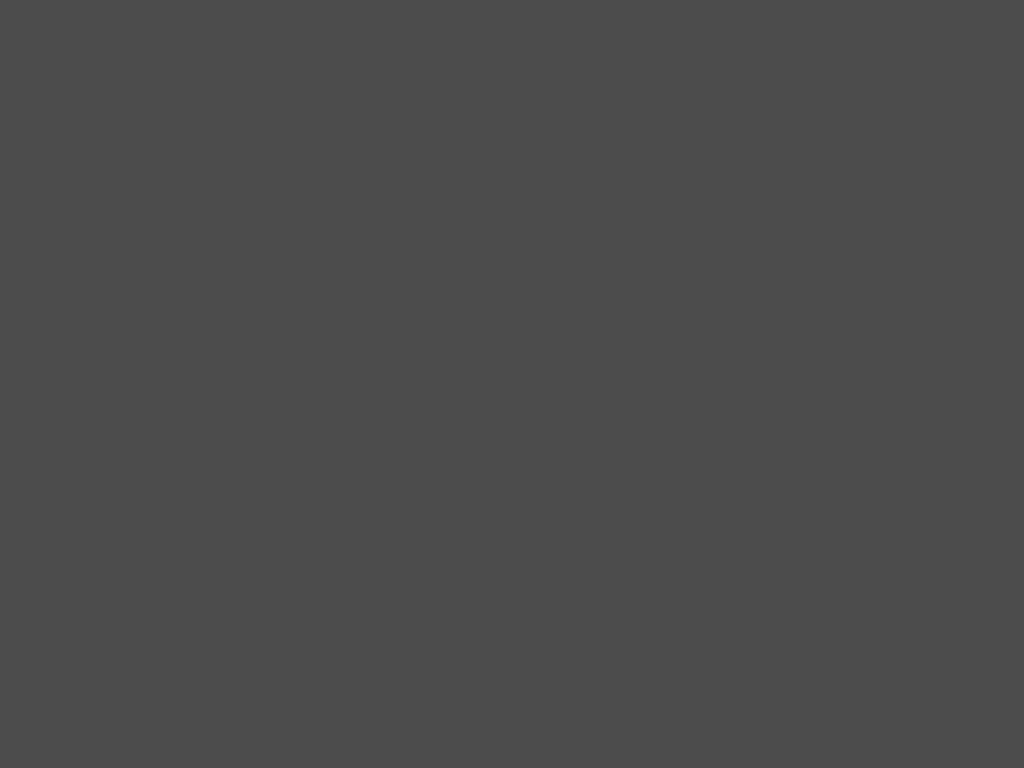

In [33]:
gpv = Vista(geo_model)



gpv.show()